## Название проекта: Мобильные приложения — Анализ поведения пользователей в мобильном приложении "Ненужные вещи"

## Цель: 

сделать приложение "Ненужные вещи" удобнее и лучше.

## Задача:

Проведение аналитического анализа для prodact maneger:

- Проанализировать связь целевого события — просмотра контактов — и других действий пользователей.

- Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты:

- Провести исследовательский анализ данных

- Проанализировать влияние событий на совершение целевого события

- Проверить статистические гипотезы

## Этапы анализа

### Первый этап

Загрузка данных ('/mobile_dataset.csv'; '/mobile_sources.csv')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import statsmodels.stats.proportion as proportion
from datetime import datetime, timedelta
import plotly.express as px
import re
from io import BytesIO
import requests
import math as mth
import math
from scipy.stats import norm


In [2]:
data_source = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
data_source.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
data.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


### Второй этап:

Исследовательский анализ данных (EDA)

#### Изменение названий столбцов/значений

In [4]:
data = data.rename(columns={'user.id':'user_id', 'event.name': 'event_name', 'event.time': 'event_time'})
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [5]:
# объединим два одинаковых действия
data.loc[data.event_name=='contacts_show', 'event_name'] = 'show_contacts'

#### Проверка типа данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [7]:
# изменим формат столбца 'event_time'
data['event_time']=pd.to_datetime(data['event_time'])
data['event_time']

0       2019-10-07 00:00:00.431357
1       2019-10-07 00:00:01.236320
2       2019-10-07 00:00:02.245341
3       2019-10-07 00:00:07.039334
4       2019-10-07 00:00:56.319813
                   ...            
74192   2019-11-03 23:53:29.534986
74193   2019-11-03 23:54:00.407086
74194   2019-11-03 23:56:57.041825
74195   2019-11-03 23:57:06.232189
74196   2019-11-03 23:58:12.532487
Name: event_time, Length: 74197, dtype: datetime64[ns]

#### Выделение столбца с датой

In [8]:
data['event_date'] = pd.to_datetime(data['event_time']).dt.date
data.head()

,event_time,event_name,user_id,event_date
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07


#### Проверка пропусков

In [9]:
data.isna().sum()

event_time    0
event_name    0
user_id       0
event_date    0
dtype: int64

#### Проверка на дубликаты

In [10]:
data.duplicated().sum()

0

При проверке данных на дубликаты и пропуски, ошибок не было выявлено. Произведена замена типа данных столбца 'event_time'. И выделен столбец только с датой. Объединили два одинаковых действия в одно. Изменили названия столбцов на более удобные.

### Изучение данных

#### Сколько всего событий в логе?

In [11]:
data['event_name'].count()

74197

In [12]:
len(data['event_name'].unique())

15

Всего событий в логе 74197. Уникальных событий: 15.

#### Сколько всего пользователей в логе?

In [13]:
len(data['user_id'].unique())

4293

Уникальных пользователей 4293.

#### Сколько в среднем событий приходится на пользователя?

In [14]:
df = data.groupby('user_id')['event_name'].count().reset_index(name='count_event')
df.head()

,user_id,count_event
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8


In [15]:
df['count_event'].mean().round()

17.0

В среднем на пользователя приходится 17 событий.

#### Данными за какой период располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени.

In [16]:
data['event_time'].min()

Timestamp('2019-10-07 00:00:00.431357')

In [17]:
data['event_time'].max()

Timestamp('2019-11-03 23:58:12.532487')

У нас имеются данные за период с 07.10.2019 по 03.11.2019.

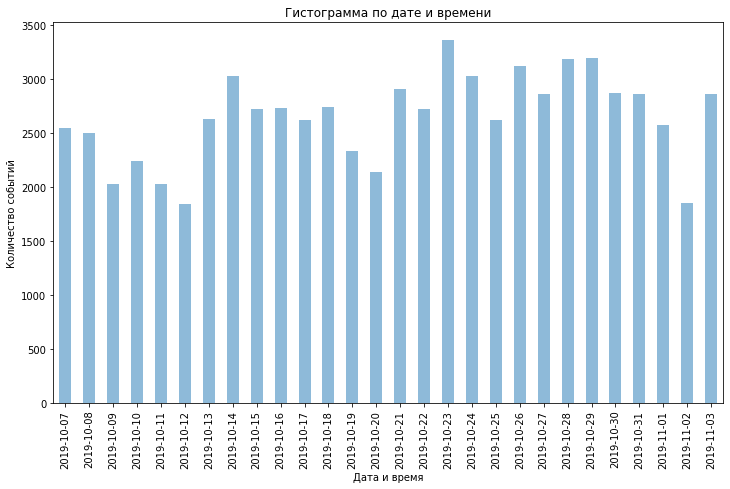

In [18]:
data.groupby('event_date')['event_name'].count().T.plot(kind='bar', alpha=0.5, figsize=(12, 7), title='Гистограмма по дате и времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.show()

Мы располагаем полными данными за весь период.

### Изучение воронки событий:

#### Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [19]:
# получим список событий
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'show_contacts', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

In [20]:
# отсортируем события по популярности
data.groupby('event_name')['event_name'].count().sort_values()

event_name
search_7           222
search_2           324
search_6           460
search_3           522
contacts_call      541
search_4           701
tips_click         814
search_5          1049
favorites_add     1417
search_1          3506
map               3881
show_contacts     4529
advert_open       6164
photos_show      10012
tips_show        40055
Name: event_name, dtype: int64

#### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.

In [21]:
data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
tips_show,2801
map,1456
photos_show,1095
show_contacts,981
search_1,787
advert_open,751
search_5,663
search_4,474
favorites_add,351


#### Посчитаем долю пользователей, которые хоть раз совершали событие. 

In [22]:
data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False) / len(data['user_id'].unique()) * 100

,user_id
event_name,
tips_show,65.245749
map,33.915677
photos_show,25.506639
show_contacts,22.851153
search_1,18.332169
advert_open,17.493594
search_5,15.443746
search_4,11.041230
favorites_add,8.176101


#### Получим сессии пользователей

In [26]:
# отсортируем таблицу по пользователям и времени
data = data.sort_values(['user_id', 'event_time'])
data.head()

,event_time,event_name,user_id,event_date
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07


In [27]:
data['event_id'] = np.arange(data.shape[0])
data.head()

,event_time,event_name,user_id,event_date,event_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4


In [28]:
# Найдем такие события, которые будут начальными точками для сессий 
data['diff'] = data.groupby('user_id')['event_time'].diff(1)
data.head()

,event_time,event_name,user_id,event_date,event_id,diff
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041


Из основного датафрейма data создадим вспомогательный датафрейм 'session_start_df'. Этот датафрейм будет содержать события, которые будут считаться первыми событиями сессий. К таким событиям относятся все события, которые произошли спустя более чем 60 минут после предыдущего, либо события, которые были первыми для пользователя (NaT в колонке 'diff').

Также создадим во вспомогательном датафрейме колонку 'session_id', которая будет содержать в себе 'enent_id' первого события сессии. Она пригодится, чтобы корректно отобразить идентификатор сессии, когда будем объединять данные из основного и вспомогательного датафреймов.

In [29]:
sessions_start_df = data[(data['diff'].isnull()) | (data['diff'] > '3600 seconds')]
sessions_start_df['session_id'] = sessions_start_df['event_id']
sessions_start_df.head()

/tmp/ipykernel_99/476018612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sessions_start_df['session_id'] = sessions_start_df['event_id']


,event_time,event_name,user_id,event_date,event_id,diff,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,9,2 days 04:44:13.861346,9
36412,2019-10-21 19:52:30.778932,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,13,12 days 01:10:07.814984,13
37556,2019-10-22 11:18:14.635436,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,27,0 days 15:10:44.584408,27
31632,2019-10-19 21:34:33.849769,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,35,NaT,35


С помощью функции merge_asof объединим между собой данные основного и вспомогательного датафреймов. Эта функция позволяет объединить данные двух датафреймов не по точному соответствию ключей, а по ближайшему. 

Для корректной работы функции merge_asof оба датафрейма должны быть отсортированы по ключу, на основе которого будет происходить объединение. В нашем случае это колонка 'event_id'.

In [30]:
data = data.sort_values('event_id')
sessions_start_df = sessions_start_df.sort_values('event_id')
data = pd.merge_asof(data,sessions_start_df[['event_id','user_id','session_id']],on='event_id',by='user_id')
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0


In [31]:
data['session_id'].nunique()

9573

In [32]:
# создадим датафрейм с номером сессии, которая содержит действие 'show_contacts'
data_show_contacts=data[(data.event_name=='show_contacts')].groupby(['session_id'])\
        .agg(number_show_contacts=('event_name','nunique')).reset_index()
data_show_contacts.head()

,session_id,number_show_contacts
0,44,1
1,71,1
2,91,1
3,105,1
4,148,1


In [33]:
data_show_contacts['session_id'].nunique()

1618

In [34]:
# присоединим полученыый датафрейм к основной таблице data
data = data.merge(data_show_contacts, on='session_id', how='left')
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN


Найдем события, которые были первыми в логах.

In [35]:
def first_event_in_session(row):
    if row['event_id'] == row['session_id']:
        return '1'
    else:
        return '0'

In [36]:
data['is_first_event_in_session'] = data.apply(lambda x: first_event_in_session(x), axis=1)
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN,1
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN,0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN,0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN,0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN,0


Вычислим время, проведенное на странице, руководствуясь временем посещения следующей страницы.

Для этого сначала считаем разницу между предыдущей и следующей страницей внутри сессии.

In [37]:
data['time_on_page'] = data.groupby(['session_id'])['event_time'].diff(1)
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN,1,NaT
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN,0,0 days 00:00:45.063550
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN,0,0 days 00:00:34.669580
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN,0,0 days 00:02:15.012972
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN,0,0 days 00:02:10.182041


Теперь нужно сдвинуть значение столбца 'time_on_page' на одну строку вверх внутри отдельно взятой сессии.

In [38]:
data['time_on_page'] = data.groupby(['session_id'])['time_on_page'].shift(-1)
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN,1,0 days 00:00:45.063550
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN,0,0 days 00:00:34.669580
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN,0,0 days 00:02:15.012972
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN,0,0 days 00:02:10.182041
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN,0,0 days 00:00:12.294838


In [39]:
# преобразуем 'time_on_page' в секунды.
data['time_on_page'] = data['time_on_page'] / np.timedelta64(1, 's')
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN,1,45.063550
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN,0,34.669580
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN,0,135.012972
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN,0,130.182041
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN,0,12.294838


Вычислим длительность каждой сессии.

In [40]:
data['sum_time_session'] = data.groupby(['session_id']).agg({'time_on_page':'sum'})
data.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN,1,45.063550,595.727258
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN,0,34.669580,NaN
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN,0,135.012972,NaN
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN,0,130.182041,NaN
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN,0,12.294838,NaN


Вычислим время до совершения целевого действия в разных сценариях.

In [41]:
# найдем время первого встречающегося пункта 'show_contacts' в сессии и создадим новый датафрейм
filtr_show_contacts = data[data.event_name=='show_contacts'].groupby(['session_id']).agg(date_show_contacts=('event_time','min'))
filtr_show_contacts.head()

,date_show_contacts
session_id,
44,2019-10-20 19:17:18.659799
71,2019-10-29 21:26:40.258472
91,2019-10-30 08:01:05.420773
105,2019-11-03 17:12:09.708771
148,2019-10-25 16:44:41.263364


In [42]:
# присоединим получившийся датафрейм к основной таблице
df_session = data.merge(filtr_show_contacts, on=['session_id'], how='left')
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,0,NaN,1,45.063550,595.727258,NaT
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,1,0 days 00:00:45.063550,0,NaN,0,34.669580,NaN,NaT
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2,0 days 00:00:34.669580,0,NaN,0,135.012972,NaN,NaT
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,3,0 days 00:02:15.012972,0,NaN,0,130.182041,NaN,NaT
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,4,0 days 00:02:10.182041,0,NaN,0,12.294838,NaN,NaT


In [43]:
# отбросим данные, которые происходили после 'show_contacts'
df_session=df_session[df_session.event_time<=df_session.date_show_contacts]
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799
45,2019-10-20 18:59:22.541082,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,45,0 days 00:09:58.425448,44,1.0,0,219.488922,NaN,2019-10-20 19:17:18.659799
46,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,46,0 days 00:03:39.488922,44,1.0,0,74.119730,NaN,2019-10-20 19:17:18.659799
47,2019-10-20 19:04:16.149734,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,47,0 days 00:01:14.119730,44,1.0,0,340.012830,NaN,2019-10-20 19:17:18.659799
48,2019-10-20 19:09:56.162564,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,48,0 days 00:05:40.012830,44,1.0,0,111.181732,NaN,2019-10-20 19:17:18.659799


In [44]:
# добавим столбец с началом сессии
df_session['session_start']=df_session.groupby('session_id')['event_time'].min()
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799,2019-10-20 18:49:24.115634
45,2019-10-20 18:59:22.541082,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,45,0 days 00:09:58.425448,44,1.0,0,219.488922,NaN,2019-10-20 19:17:18.659799,NaT
46,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,46,0 days 00:03:39.488922,44,1.0,0,74.119730,NaN,2019-10-20 19:17:18.659799,NaT
47,2019-10-20 19:04:16.149734,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,47,0 days 00:01:14.119730,44,1.0,0,340.012830,NaN,2019-10-20 19:17:18.659799,NaT
48,2019-10-20 19:09:56.162564,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,48,0 days 00:05:40.012830,44,1.0,0,111.181732,NaN,2019-10-20 19:17:18.659799,NaT


In [45]:
# добавим столбец с шагами, входящими в сессию
df_session['user_path']=df_session.groupby('session_id')['event_name'].apply(list)
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799,2019-10-20 18:49:24.115634,"[search_1, photos_show, favorites_add, search_..."
45,2019-10-20 18:59:22.541082,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,45,0 days 00:09:58.425448,44,1.0,0,219.488922,NaN,2019-10-20 19:17:18.659799,NaT,NaN
46,2019-10-20 19:03:02.030004,favorites_add,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,46,0 days 00:03:39.488922,44,1.0,0,74.119730,NaN,2019-10-20 19:17:18.659799,NaT,NaN
47,2019-10-20 19:04:16.149734,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,47,0 days 00:01:14.119730,44,1.0,0,340.012830,NaN,2019-10-20 19:17:18.659799,NaT,NaN
48,2019-10-20 19:09:56.162564,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,48,0 days 00:05:40.012830,44,1.0,0,111.181732,NaN,2019-10-20 19:17:18.659799,NaT,NaN


In [46]:
# оставим в таблице данные о первой странице
df_session=df_session[df_session.is_first_event_in_session=='1']
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799,2019-10-20 18:49:24.115634,"[search_1, photos_show, favorites_add, search_..."
71,2019-10-29 21:18:24.850073,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29,71,5 days 10:21:12.174963,71,1.0,1,70.539719,3120.862767,2019-10-29 21:26:40.258472,2019-10-29 21:18:24.850073,"[search_1, photos_show, photos_show, search_1,..."
91,2019-10-30 07:50:45.948358,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-30,91,0 days 09:40:20.235518,91,1.0,1,146.781695,2167.984818,2019-10-30 08:01:05.420773,2019-10-30 07:50:45.948358,"[search_1, photos_show, photos_show, search_1,..."
105,2019-11-03 17:12:09.708771,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,105,4 days 08:45:15.775595,105,1.0,1,NaN,0.000000,2019-11-03 17:12:09.708771,2019-11-03 17:12:09.708771,[show_contacts]
148,2019-10-25 16:44:41.263364,show_contacts,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,148,NaT,148,1.0,1,3.523496,3.523496,2019-10-25 16:44:41.263364,2019-10-25 16:44:41.263364,[show_contacts]


In [47]:
# вычислим время до целевого действия в каждой сессии
df_session['time_to_show_contacts']=df_session.date_show_contacts-df_session.session_start
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path,time_to_show_contacts
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799,2019-10-20 18:49:24.115634,"[search_1, photos_show, favorites_add, search_...",0 days 00:27:54.544165
71,2019-10-29 21:18:24.850073,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29,71,5 days 10:21:12.174963,71,1.0,1,70.539719,3120.862767,2019-10-29 21:26:40.258472,2019-10-29 21:18:24.850073,"[search_1, photos_show, photos_show, search_1,...",0 days 00:08:15.408399
91,2019-10-30 07:50:45.948358,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-30,91,0 days 09:40:20.235518,91,1.0,1,146.781695,2167.984818,2019-10-30 08:01:05.420773,2019-10-30 07:50:45.948358,"[search_1, photos_show, photos_show, search_1,...",0 days 00:10:19.472415
105,2019-11-03 17:12:09.708771,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,105,4 days 08:45:15.775595,105,1.0,1,NaN,0.000000,2019-11-03 17:12:09.708771,2019-11-03 17:12:09.708771,[show_contacts],0 days 00:00:00
148,2019-10-25 16:44:41.263364,show_contacts,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,148,NaT,148,1.0,1,3.523496,3.523496,2019-10-25 16:44:41.263364,2019-10-25 16:44:41.263364,[show_contacts],0 days 00:00:00


In [48]:
# переведем столбец'time_to_show_contacts' в секунды. Полученные данные сохраним в новый столбец. 
df_session['sec_to_show_contacts'] = df_session['time_to_show_contacts'] / np.timedelta64(1, 's')
df_session.head()                                               

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path,time_to_show_contacts,sec_to_show_contacts
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799,2019-10-20 18:49:24.115634,"[search_1, photos_show, favorites_add, search_...",0 days 00:27:54.544165,1674.544165
71,2019-10-29 21:18:24.850073,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29,71,5 days 10:21:12.174963,71,1.0,1,70.539719,3120.862767,2019-10-29 21:26:40.258472,2019-10-29 21:18:24.850073,"[search_1, photos_show, photos_show, search_1,...",0 days 00:08:15.408399,495.408399
91,2019-10-30 07:50:45.948358,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-30,91,0 days 09:40:20.235518,91,1.0,1,146.781695,2167.984818,2019-10-30 08:01:05.420773,2019-10-30 07:50:45.948358,"[search_1, photos_show, photos_show, search_1,...",0 days 00:10:19.472415,619.472415
105,2019-11-03 17:12:09.708771,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,105,4 days 08:45:15.775595,105,1.0,1,NaN,0.000000,2019-11-03 17:12:09.708771,2019-11-03 17:12:09.708771,[show_contacts],0 days 00:00:00,0.000000
148,2019-10-25 16:44:41.263364,show_contacts,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,148,NaT,148,1.0,1,3.523496,3.523496,2019-10-25 16:44:41.263364,2019-10-25 16:44:41.263364,[show_contacts],0 days 00:00:00,0.000000


In [49]:
# изучим столбец с длительностью до целевого действия
df_session['sec_to_show_contacts'].describe()

count     1618.000000
mean       560.278548
std       1101.490171
min          0.000000
25%          0.000000
50%        118.888987
75%        591.307681
max      16364.139818
Name: sec_to_show_contacts, dtype: float64

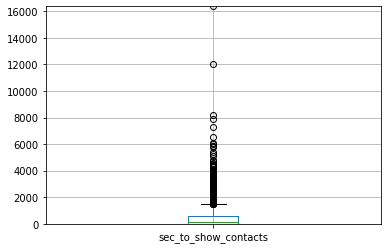

In [50]:
df_session.boxplot(column='sec_to_show_contacts')
plt.ylim(0, 16364.139818)
plt.show()

array([[<AxesSubplot:title={'center':'sec_to_show_contacts'}>]],
      dtype=object)

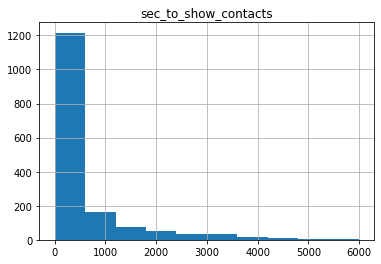

In [51]:
df_session.hist('sec_to_show_contacts', range = (0, 6000))

In [52]:
# выделим столбец сессий с уникальными шагами
df_session['unique_events_path']=df_session['user_path'].apply(lambda x: list(dict.fromkeys(x)))
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path,time_to_show_contacts,sec_to_show_contacts,unique_events_path
44,2019-10-20 18:49:24.115634,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-20,44,0 days 20:49:29.478536,44,1.0,1,598.425448,4572.118439,2019-10-20 19:17:18.659799,2019-10-20 18:49:24.115634,"[search_1, photos_show, favorites_add, search_...",0 days 00:27:54.544165,1674.544165,"[search_1, photos_show, favorites_add, show_co..."
71,2019-10-29 21:18:24.850073,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-29,71,5 days 10:21:12.174963,71,1.0,1,70.539719,3120.862767,2019-10-29 21:26:40.258472,2019-10-29 21:18:24.850073,"[search_1, photos_show, photos_show, search_1,...",0 days 00:08:15.408399,495.408399,"[search_1, photos_show, show_contacts]"
91,2019-10-30 07:50:45.948358,search_1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-30,91,0 days 09:40:20.235518,91,1.0,1,146.781695,2167.984818,2019-10-30 08:01:05.420773,2019-10-30 07:50:45.948358,"[search_1, photos_show, photos_show, search_1,...",0 days 00:10:19.472415,619.472415,"[search_1, photos_show, show_contacts]"
105,2019-11-03 17:12:09.708771,show_contacts,00157779-810c-4498-9e05-a1e9e3cedf93,2019-11-03,105,4 days 08:45:15.775595,105,1.0,1,NaN,0.000000,2019-11-03 17:12:09.708771,2019-11-03 17:12:09.708771,[show_contacts],0 days 00:00:00,0.000000,[show_contacts]
148,2019-10-25 16:44:41.263364,show_contacts,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,148,NaT,148,1.0,1,3.523496,3.523496,2019-10-25 16:44:41.263364,2019-10-25 16:44:41.263364,[show_contacts],0 days 00:00:00,0.000000,[show_contacts]


In [53]:
# отбросим нулевые сессии
df_session = df_session[df_session.time_to_show_contacts>'00:00:00'].sort_values(by='time_to_show_contacts')
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path,time_to_show_contacts,sec_to_show_contacts,unique_events_path
22021,2019-10-14 14:15:20.400785,favorites_add,4b496ab7-92be-42da-a932-6b0dd270edfa,2019-10-14,22021,0 days 01:37:17.334652,22021,1.0,1,0.158918,0.158918,2019-10-14 14:15:20.559703,2019-10-14 14:15:20.400785,"[favorites_add, show_contacts]",0 days 00:00:00.158918,0.158918,"[favorites_add, show_contacts]"
72816,2019-10-19 15:49:38.635149,tips_show,fbdabf5f-ea95-47d5-96b3-75e136336477,2019-10-19,72816,0 days 06:03:46.830401,72816,1.0,1,0.263470,58.598365,2019-10-19 15:49:38.898619,2019-10-19 15:49:38.635149,"[tips_show, show_contacts]",0 days 00:00:00.263470,0.263470,"[tips_show, show_contacts]"
70976,2019-10-17 11:38:26.471067,tips_show,f553a25f-67a7-4c5b-ab08-9f56a388cdb4,2019-10-17,70976,0 days 03:12:51.246472,70976,1.0,1,0.294110,0.294110,2019-10-17 11:38:26.765177,2019-10-17 11:38:26.471067,"[tips_show, show_contacts]",0 days 00:00:00.294110,0.294110,"[tips_show, show_contacts]"
23114,2019-10-17 12:36:28.474307,tips_show,515e9d9f-a690-4a30-8b05-b948d267e538,2019-10-17,23114,0 days 18:53:23.656605,23114,1.0,1,0.728009,0.728009,2019-10-17 12:36:29.202316,2019-10-17 12:36:28.474307,"[tips_show, show_contacts]",0 days 00:00:00.728009,0.728009,"[tips_show, show_contacts]"
53813,2019-10-25 13:06:37.627239,tips_show,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,2019-10-25,53813,0 days 01:47:25.835264,53813,1.0,1,0.883446,0.883446,2019-10-25 13:06:38.510685,2019-10-25 13:06:37.627239,"[tips_show, show_contacts]",0 days 00:00:00.883446,0.883446,"[tips_show, show_contacts]"


In [54]:
df_session['session_id'].nunique()

1129

In [55]:
# изменим тип данных столбца 'unique_events_path'
df_session['user_path_new'] = [', '.join(map(str, l)) for l in df_session['unique_events_path']]
df_session.head()

,event_time,event_name,user_id,event_date,event_id,diff,session_id,number_show_contacts,is_first_event_in_session,time_on_page,sum_time_session,date_show_contacts,session_start,user_path,time_to_show_contacts,sec_to_show_contacts,unique_events_path,user_path_new
22021,2019-10-14 14:15:20.400785,favorites_add,4b496ab7-92be-42da-a932-6b0dd270edfa,2019-10-14,22021,0 days 01:37:17.334652,22021,1.0,1,0.158918,0.158918,2019-10-14 14:15:20.559703,2019-10-14 14:15:20.400785,"[favorites_add, show_contacts]",0 days 00:00:00.158918,0.158918,"[favorites_add, show_contacts]","favorites_add, show_contacts"
72816,2019-10-19 15:49:38.635149,tips_show,fbdabf5f-ea95-47d5-96b3-75e136336477,2019-10-19,72816,0 days 06:03:46.830401,72816,1.0,1,0.263470,58.598365,2019-10-19 15:49:38.898619,2019-10-19 15:49:38.635149,"[tips_show, show_contacts]",0 days 00:00:00.263470,0.263470,"[tips_show, show_contacts]","tips_show, show_contacts"
70976,2019-10-17 11:38:26.471067,tips_show,f553a25f-67a7-4c5b-ab08-9f56a388cdb4,2019-10-17,70976,0 days 03:12:51.246472,70976,1.0,1,0.294110,0.294110,2019-10-17 11:38:26.765177,2019-10-17 11:38:26.471067,"[tips_show, show_contacts]",0 days 00:00:00.294110,0.294110,"[tips_show, show_contacts]","tips_show, show_contacts"
23114,2019-10-17 12:36:28.474307,tips_show,515e9d9f-a690-4a30-8b05-b948d267e538,2019-10-17,23114,0 days 18:53:23.656605,23114,1.0,1,0.728009,0.728009,2019-10-17 12:36:29.202316,2019-10-17 12:36:28.474307,"[tips_show, show_contacts]",0 days 00:00:00.728009,0.728009,"[tips_show, show_contacts]","tips_show, show_contacts"
53813,2019-10-25 13:06:37.627239,tips_show,be1449f6-ca45-4f94-93a7-ea4b079b8f0f,2019-10-25,53813,0 days 01:47:25.835264,53813,1.0,1,0.883446,0.883446,2019-10-25 13:06:38.510685,2019-10-25 13:06:37.627239,"[tips_show, show_contacts]",0 days 00:00:00.883446,0.883446,"[tips_show, show_contacts]","tips_show, show_contacts"


#### Построение воронок

In [56]:
# получим воронки событий и сохраним в новый датафрейм, отсортируем по времени и сделаем подсчет сессий, входящих в каждую воронку
session_short = df_session.groupby(['user_path_new']).agg({'sec_to_show_contacts': 'median', 'session_id':'count'}).reset_index().sort_values('sec_to_show_contacts')
session_short = session_short.rename(columns={'session_id':'count_session'})
session_short.head()


,user_path_new,sec_to_show_contacts,count_session
85,"search_6, search_5, show_contacts",18.376852,4
15,"favorites_add, show_contacts",27.377070,10
5,"advert_open, show_contacts",41.794021,14
83,"search_6, search_4, search_5, show_contacts",49.014948,2
65,"search_4, search_5, show_contacts",49.227703,2


Самымые быстрые пути до наступления целевого действия:
1. search_6, search_5, show_contacts (18.38 сек.)
2. favorites_add, show_contacts (27.38 сек.)
3. advert_open, show_contacts (41.79 сек.)

In [57]:
# отсортируем таблицу по количеству сессий
session_short.sort_values('count_session', ascending=False).head(50)

,user_path_new,sec_to_show_contacts,count_session
106,"tips_show, show_contacts",292.595393,377
39,"photos_show, show_contacts",248.879069,132
46,"search_1, show_contacts",136.298599,122
32,"map, tips_show, show_contacts",343.847802,101
45,"search_1, photos_show, show_contacts",602.335051,65
27,"map, show_contacts",56.915191,34
99,"tips_show, map, show_contacts",1177.465818,30
108,"tips_show, tips_click, show_contacts",1096.181021,19
5,"advert_open, show_contacts",41.794021,14
38,"photos_show, search_1, show_contacts",893.230941,13


Тройка наиболее популярных воронок кардинально отличается от лидеров быстрых воронок:
1. tips_show, show_contacts (292.59 сек.)
2. photos_show, show_contacts (248.88 сек.)
3. search_1, show_contacts (136.30 сек.)

Ниже посмотрим какой процент занимают воронки с наиболее популярными событиями.

In [58]:
sum([session_short[session_short.user_path_new.str.startswith(h)].count_session.sum() \
 for h in ['tips_show', 'photos_show', 'search_1', 'map']])/session_short.count_session.sum() * 100

86.7139061116032

Воронки с наиболее популярными событиями занимают 86,7%. Пользователи чаще начинают свой путь с просмотра рекомендованных объявлений, просмотра фотографий и поиска.

### Проверка первой гипотезы

H0 - конверсия в просмотры контактов не различается у двух групп(одни пользователи совершают действия 'tips_show' и 'tips_click', другие — только 'tips_show').

H1 - конверсия в просмотры контактов различается у двух групп(одни пользователи совершают действия 'tips_show' и 'tips_click',
другие — только 'tips_show').

#### Деление пользователей на две группы

In [59]:
def split_into_groups(data):
    filtr_data1 = data[(data.event_name=='tips_show')|(data.event_name=='tips_click')].groupby(['user_id'])\
        .agg(count_events_tips=('event_name','nunique')).reset_index()
    filtr_data1=filtr_data1[filtr_data1.count_events_tips==2]
    filtr_data2 = data[(data.event_name=='tips_show')&(~data.user_id.isin(filtr_data1.user_id.tolist()))].groupby(['user_id'])\
        .agg(count_events_tips=('event_name','nunique')).reset_index()
    filtr_users=pd.concat([filtr_data1, filtr_data2])
    users_show_contacts=data[(data.event_name=='show_contacts')].groupby(['user_id'])\
        .agg(event_show_contacts=('event_name','nunique')).reset_index()
 
    df_groups=filtr_users.merge(users_show_contacts, how='left', on='user_id')
    df_groups[['event_show_contacts']] = df_groups[['event_show_contacts']].fillna(value=0)
    
    return df_groups

In [60]:
df_groups=split_into_groups(data)
df_groups.head()

,user_id,count_events_tips,event_show_contacts
0,01147bf8-cd48-49c0-a5af-3f6eb45f8262,2,0.0
1,01b4ca51-930d-4518-aa09-8a8c35e1d9cc,2,0.0
2,02e7c193-842b-4995-b67a-8c87ac0f29bb,2,0.0
3,04ee0c31-3c77-49f8-81d2-bbfe9fe2cde8,2,0.0
4,0656a1d1-9032-43ae-b936-11e41526eeff,2,0.0


In [61]:
trials1=df_groups[df_groups.count_events_tips==1].user_id.count()
trials2=df_groups[df_groups.count_events_tips==2].user_id.count()
successes1=df_groups[(df_groups.count_events_tips==1)&(df_groups.event_show_contacts==1)].user_id.count()
successes2=df_groups[(df_groups.count_events_tips==2)&(df_groups.event_show_contacts==1)].user_id.count()
chi2stat, pval, table=proportion.proportions_chisquare([successes1,successes2],[trials1,trials2])
alpha=0.05
if pval<alpha:
    print(f"{round(successes1/trials1, 2), round(successes2/trials2,2)} - статистически значимая разница конверсий обнаружна. Нулевую гипотезу отвергаем.")
else:
    print(f"{round(successes1/trials1, 2), round(successes2/trials2,2)} - статистически значимой разницы конверсий не обнаружно. Нулевую гипотезу не отвергаем.")

(0.17, 0.31) - статистически значимая разница конверсий обнаружна. Нулевую гипотезу отвергаем.


#### Посчет числа пользователей, совершивших целевое событие в каждой из контрольных групп

In [62]:
df_groups[(df_groups.count_events_tips==1)&(df_groups.event_show_contacts==1)]['user_id'].count()

425

In [63]:
df_groups[(df_groups.count_events_tips==2)&(df_groups.event_show_contacts==1)]['user_id'].count()

91

#### Посчет доли пользователей, совершивших целевое событие 

In [64]:
df_groups[(df_groups.count_events_tips==1)&(df_groups.event_show_contacts==1)]['user_id'].count() / df_groups[df_groups.count_events_tips==1]['user_id'].count() * 100

16.972843450479232

In [65]:
df_groups[(df_groups.count_events_tips==2)&(df_groups.event_show_contacts==1)]['user_id'].count() / df_groups[df_groups.count_events_tips==2]['user_id'].count() * 100

30.63973063973064

### Проверка второй гипотезы

H0 - конверсия в просмотры контактов не различается у двух групп(одни пользователи совершают действия 'photos_show',  другие — нет).

H1 - конверсия в просмотры контактов различается у двух групп(одни пользователи совершают действия 'photos_show', другие — нет).

#### Разделим пользователей на две группы

In [66]:
def split_groups(data):
    group_a = data[data.event_name=='photos_show'].groupby(['user_id'])\
        .agg(count_tips=('event_name','nunique')).reset_index()
    group_a['groups_ab']="a"
    group_b = data[(data.event_name!='photos_show')&(~data.user_id.isin(group_a.user_id.tolist()))].groupby(['user_id'])\
        .agg(count_tips=('event_name','nunique')).reset_index()
    group_b['groups_ab']="b"
    groups=pd.concat([group_a, group_b])
    users_contacts=data[(data.event_name=='show_contacts')].groupby(['user_id'])\
        .agg(event_contacts=('event_name','nunique')).reset_index()
 
    groups_a_b=groups.merge(users_contacts, how='left', on='user_id')
    groups_a_b[['event_contacts']] = groups_a_b[['event_contacts']].fillna(value=0)
    
    return groups_a_b

In [67]:
groups_a_b=split_groups(data)
groups_a_b.head()

,user_id,count_tips,groups_ab,event_contacts
0,00157779-810c-4498-9e05-a1e9e3cedf93,1,a,1.0
1,00463033-5717-4bf1-91b4-09183923b9df,1,a,0.0
2,00551e79-152e-4441-9cf7-565d7eb04090,1,a,1.0
3,00653802-5ff1-4071-bc17-347fc4cef569,1,a,0.0
4,006a32d4-ee10-40dc-b237-11e0fde81cbc,1,a,0.0


In [68]:
groups_a_b['groups_ab'].unique()

array(['a', 'b'], dtype=object)

In [69]:
trials1=groups_a_b[groups_a_b.groups_ab=='a'].user_id.count()
trials2=groups_a_b[groups_a_b.groups_ab=='b'].user_id.count()
successes1=groups_a_b[(groups_a_b.groups_ab=='a')&(groups_a_b.event_contacts==1)].user_id.count()
successes2=groups_a_b[(groups_a_b.groups_ab=='b')&(groups_a_b.event_contacts==1)].user_id.count()
chi2stat, pval, table=proportion.proportions_chisquare([successes1,successes2],[trials1,trials2])
alpha=0.05
if pval<alpha:
    print(f"{round(successes1/trials1, 2), round(successes2/trials2,2)} - статистически значимая разница конверсий обнаружна. Нулевую гипотезу отвергаем.")
else:
    print(f"{round(successes1/trials1, 2), round(successes2/trials2,2)} - статистически значимой разницы конверсий не обнаружно. Нулевую гипотезу не отвергаем.")

(0.31, 0.2) - статистически значимая разница конверсий обнаружна. Нулевую гипотезу отвергаем.


#### Посчет доли пользователей, совершивших целевое событие

In [70]:
groups_a_b[(groups_a_b.groups_ab=='a')&(groups_a_b.event_contacts==1)].user_id.count() / groups_a_b[groups_a_b.groups_ab=='a'].user_id.count() * 100

30.958904109589042

In [71]:
groups_a_b[(groups_a_b.groups_ab=='b')&(groups_a_b.event_contacts==1)].user_id.count() / groups_a_b[groups_a_b.groups_ab=='b'].user_id.count() * 100

20.075046904315197

#### Посчет числа пользователей, совершивших целевое событие в каждой из контрольных групп

In [72]:
groups_a_b[(groups_a_b.groups_ab=='a')&(groups_a_b.event_contacts==1)].user_id.count()

339

In [73]:
groups_a_b[(groups_a_b.groups_ab=='b')&(groups_a_b.event_contacts==1)].user_id.count()

642

### Выводы и рекомендации.

  Для построения воронок событий, сначала мы выделили сессии пользователей. Оставили сессии в которых есть целевое действие 'show_contacts'. Вычислили время до наступления целевого действия. Отбросили нулевые сессии. Создали список шагов, входящих в каждую сессию.
  
  Для построения воронок сгруппировали датафрейм по столбцу, содержащего списки шагов. Отсортировали полученую таблицу по времени, и получили воронки с минимальным временем до наступления целевого действия. Тройка лидеров воронок:
  
  1.search_6, search_5, show_contacts (18.38 сек.)
  
  2.favorites_add, show_contacts (27.38 сек.)
  
  3.advert_open, show_contacts (41.79 сек.)
  
  Следующим шагом была проверка наиболее популярных воронок. Получилась следующая тройка лидеров:
  
  1. tips_show, show_contacts (292.59 сек.)
  
  2. photos_show, show_contacts (248.88 сек.)
  
  3. search_1, show_contacts (136.30 сек.)
  
  Данная проверка показала, что самые быстрые воронки не являются самыми популярными.
  
  Дальше мы посмотрели какой процент занимают воронки с наиболее популярными событиями. И получили результат - 86,7%, т.е пользователи, которые просматривают контакты, чаще совершают данные действия. 
  
  Чаще всего пользователи начинают свой путь с просмотра рекомендованных объявлений, просмотра фото и поиска.
  
  Следующим шагом была проверка гипотез. Результатом проверки гипотезы о равенстве конверсий в просмотры контактов у двух групп(одни пользователи совершают действия 'tips_show' и 'tips_click', другие — только 'tips_show'): статистически значимая разница конверсий обнаружна.
  
  Также было выявлено, что конверсия в просмотры контактов у группы пользователей совершивших два действия('tips_show' и 'tips_click') выше(30.64%), чем у группы, которая совершила одно действие 'tips_show' - 16.97%. Значит рекомендованные объявления нужно показывать более персонализировано.
  
  Результатом проверки гипотезы о равенстве конверсий в просмотры контактов у двух групп(одни пользователи совершают действия 'photos_show', другие — нет): статистически значимая разница конверсий обнаружна.
  
  Также было выявлено, что конверсия в просмотры контактов у группы пользователей совершивших действие 'photos_show' выше(30.95%), чем у группы пользователей не совершавших данное действие(20.07%). Нужно уделить внимание этому этапу: проверить скорость загрузки фото; желательно, чтобы объявление содержало фото; удобство просмотра фото.
  
  Рекомендации:
  
  Мы выяснили какие воронки и шаги, входящие в них, являются наиболее быстрыми до наступления целевого действия. Но они не являются популярными. Быстрый результат дают такие действия, как search_6, search_5 - это шаги поиска, 'favorites_add'  и 'advert_open' значит можно рекомендовать предпринять действия для их популяризации у пользователей:
  
  - может следует сделать всплывающее окно поиска 
  
  - изменить интерфейс поиска 
  
  - сделать поиск более точным
  
  - предлагать добавить объявление в 'избранное'
  
  Также мы получили наиболее популярные варианты воронок для достижения целевого действия. В них входят следующие действия: 'tips_show', 'photos_show', 'search_1'. Но данные воронки не являются быстрыми.
  
  Рекомендации:
  
  - проверить скорость поиска, загрузки объявлений, фото
  
  - проверить интерфейс поиска 'search_1'
  
  - уменьшить количество рекомендованных объявлений, но сделать их наиболее точно отвечающими потребностям пользователя.
  
 
 
  
  
  

https://drive.google.com/file/d/1tuyWdhgs3SGpgg_Uu93T4hOw4CxELXno/view?usp=sharing